In [13]:
# auto-reload modules when they have changed
%reload_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from IPython.core.display import set_matplotlib_formats
from bokeh.plotting import figure, show, output_notebook, curdoc

In [15]:
from modules.load import image, timestamps
from modules.analyze import blinking_analyzer, FIDA_analyzer, levels
from modules.visualize import report
from modules.visualize import plot

In [16]:
import config.config as cfg

In [17]:
#plt.style.use('default')
plt.style.use('dark_background')
curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [18]:
image_path = cfg.image_path
timestamps_path = cfg.timestamps_path
timestamps_path_single_detector = cfg.timestamps_path_single_detector
timestamps_path_blinking = cfg.timestamps_path_blinking
timestamps_path_02 = cfg.timestamps_path_02

# create image object using image class from data loading modules
#img = image.load_from_path(image_path)
#img.preview()
#img.explore()


# create timestamps object using timestamps class from data loading modules
tt = timestamps.load_from_path(timestamps_path_blinking)
#tt.preview()
tt.explore(bin_width=0.01) 

# raw data
#tt.data['detector0']

# binned data would be useful, e.g. for FIDA analysis

In [19]:
from scipy.signal import savgol_filter

# Generate noisy signal
t = np.linspace(0, 10, 1000)
x = np.sin(t) + np.random.normal(0, 0.1, len(t))

timetrace_data = tt.get_timetrace_data()
counts0, bins0 = timetrace_data['detector0']

# Smooth signal using Savitzky-Golay filter
smoothed = savgol_filter(counts0, 30, 3)

# Plot original and smoothed signal
p = figure(width=1200, height=300, title='smoothing')
p.line(bins0*5e-9, np.append(counts0, 5), line_color='#517BA1')
p.line(bins0*5e-9, np.append(smoothed, 5), line_color='yellow')
show(p)

In [20]:
from scipy import sparse, signal
from scipy.sparse import linalg
import numpy as np
from numpy.linalg import norm
from modules.analyze import preprocessing

In [21]:
_, signal_arPLS, info = preprocessing.baseline_arPLS(counts0, 
                                                      lam=100000000, 
                                                      niter=100,
                                                      full_output=True)

p = figure(width=1200, height=300, title='smoothing')
p.line(bins0*5e-9, np.append(counts0, 5), line_color='#517BA1')
p.line(bins0*5e-9, np.append(smoothed, 5), line_color='yellow')

signal_arPLS = savgol_filter(signal_arPLS, 21, 4)
p.line(bins0*5e-9, np.append(signal_arPLS, 5), line_color='red')
show(p)

In [22]:

peaks = levels.find_levels(signal_arPLS, width=10, rel_height=60, prominence=5)

timestamps0 = tt.data['detector0'].to_numpy()
timetrace_len = timestamps0[-1]
timetrace_len_in_s = 5e-9 * timetrace_len
x = np.linspace(0, timetrace_len_in_s, len(signal_arPLS))
print(len(x))


p = figure(width=1200, height=400, title='steps')
dary = np.array(signal_arPLS)
dary -= np.average(dary)
step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
dary_step = np.convolve(dary, step, mode='valid')
ceil_dary_step = dary_step/100 - np.min(dary_step/100)

prominences = signal.peak_prominences(ceil_dary_step, peaks)[0]
print(prominences)

p.line(x, signal_arPLS*3, line_color='#517BA1', line_width=1)
p.line(x, ceil_dary_step, line_color='yellow')

for ii in range(len(peaks)):
    #plt.plot((peaks[ii], peaks[ii]), (-40, 40), 'r')
    p.line((peaks[ii]*1e-2, peaks[ii]*1e-2), (-40, 40), line_color='red')

show(p)

11561
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/2h/6xcys3mx1s7czfj28g_dc70r0000gn/T/ipykernel_53096/2649275479.py:17: PeakPropertyWarning: some peaks have a prominence of 0
  prominences = signal.peak_prominences(ceil_dary_step, peaks)[0]


173.114850155
34622970031
17311.4850155


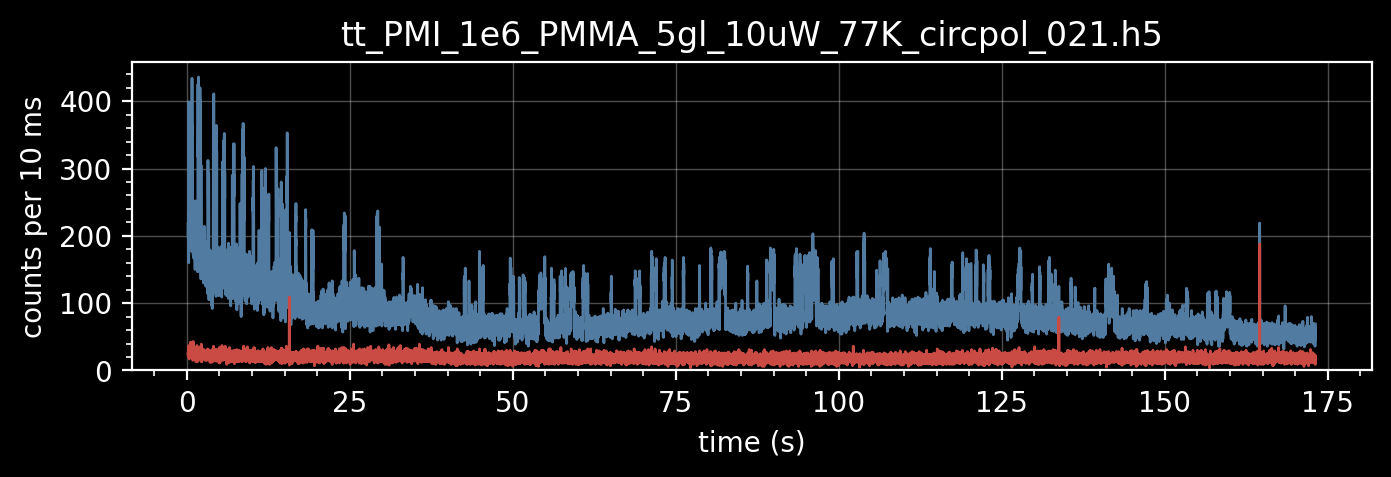

In [23]:
tt_onoff_path = cfg.tt_onoff_path
tt = timestamps.load_from_path(tt_onoff_path)

tt.preview()

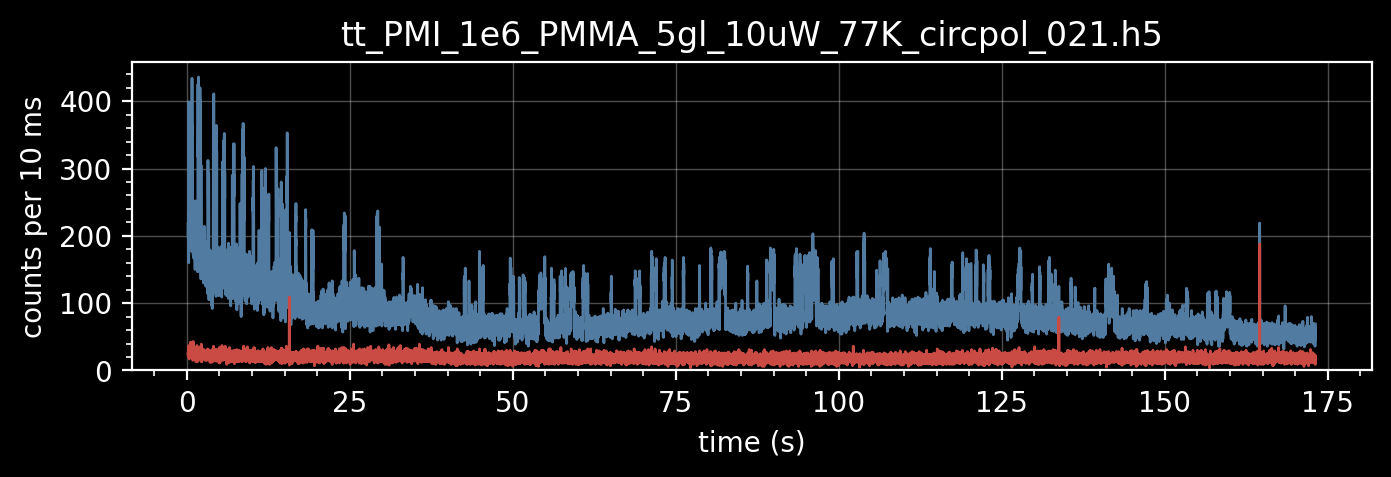

In [24]:
plot.timetrace(tt, bin_width=0.01)

/var/folders/2h/6xcys3mx1s7czfj28g_dc70r0000gn/T/ipykernel_53096/3893903793.py:38: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


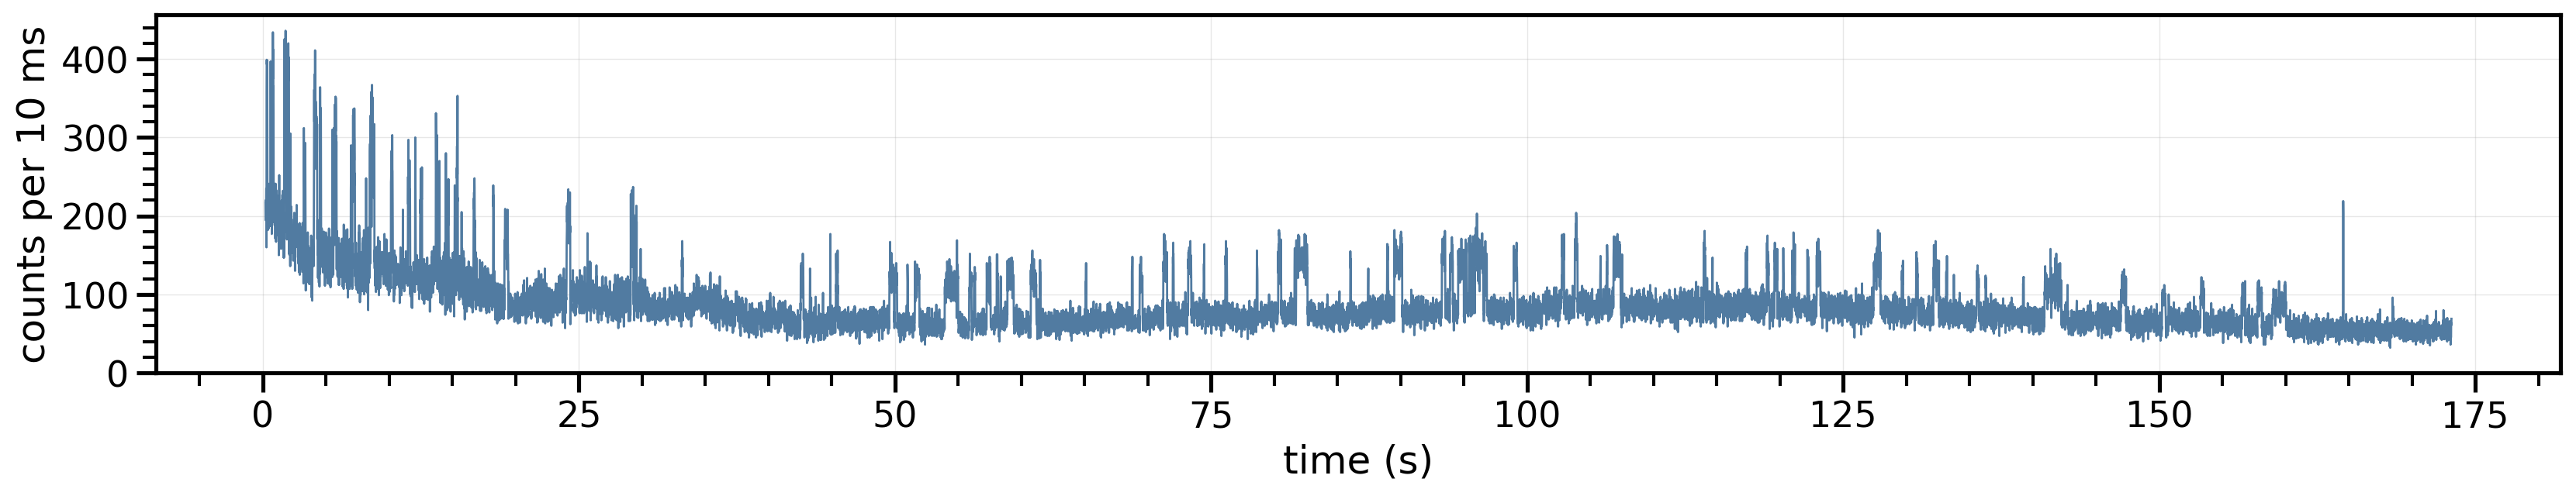

In [25]:
bin_width = 0.01
plt.style.use('default')
sns.set_context("talk")
timestamps0 = tt.data['detector0'].to_numpy()
timestamps1 = tt.data['detector1'].to_numpy()
#timestamps = self.data['detector0'].to_numpy()
timetrace_len = timestamps0[-1]
timetrace_len_in_s = timetrace_len * 5e-9
n_bins = timetrace_len_in_s/bin_width
_, ax = plt.subplots(figsize=(20, 3))
preview = sns.histplot(timestamps0, 
                       element="poly", 
                       fill=False, 
                       bins=int(np.floor(n_bins)), 
                       ax=ax,
                       linewidth=1,
                       color='#517BA1')

'''sns.histplot(timestamps1, 
                       element="poly", 
                       fill=False, 
                       bins=int(np.floor(n_bins)), 
                       ax=ax,
                       linewidth=1,
                       color='#CA4B43')'''


#plt.xlim(0)
plt.ylim(0)
preview.set(xlabel='time (s)', 
            ylabel='counts per ' + str(int(bin_width*1e3)) + ' ms',
            #title=str(tt.file_name)
            )
# Set x-axis labels to seconds using FuncFormatter
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(tt.seconds_formatter))
plt.minorticks_on()
plt.grid(linewidth = 0.5, alpha = 0.3, which = 'major')
set_matplotlib_formats('retina')
plt.style.use('default')
plt.show()

In [26]:
from scipy.signal import butter, filtfilt

def preprocess_signal(signal, cutoff_freq=1000, order=5):
    # Define the filter parameters
    nyquist_freq = 0.5 * len(signal)
    cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, cutoff, btype='low')

    # Apply the filter to the signal
    filtered_signal = filtfilt(b, a, signal)

    # Find the two levels in the filtered signal
    level1 = np.mean(filtered_signal[:len(filtered_signal)//2])
    level2 = np.mean(filtered_signal[len(filtered_signal)//2:])

    # Subtract the mean of each level from the filtered signal
    level1_signal = filtered_signal[:len(filtered_signal)//2] - level1
    level2_signal = filtered_signal[len(filtered_signal)//2:] - level2

    # Concatenate the two level signals
    restored_signal = np.concatenate((level1_signal, level2_signal))

    return restored_signal

In [27]:
preprocess_signal(tt.data['detector0'].to_numpy())

array([-6.36408150e+09, -6.36407656e+09, -6.36407160e+09, ...,
        1.03017821e+10,  1.03017821e+10,  1.03017821e+10])

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.restoration import denoise_tv_chambolle

x = counts0
x_std = (x - x.mean()) / x.std()
x_denoise = denoise_tv_chambolle(x_std, weight=1)  # adjust the parameters
x_step = -2*np.cumsum(x_denoise)
step_indicator = x_step == x_step.max()

n = x.shape[0]
plt.figure(figsize=(20, 3))
plt.plot(range(n), x_std, label='standardized')
plt.plot(range(n), x_denoise, label='denoised (TV)')

plt.xlim(0, 8000)


ModuleNotFoundError: No module named 'skimage'

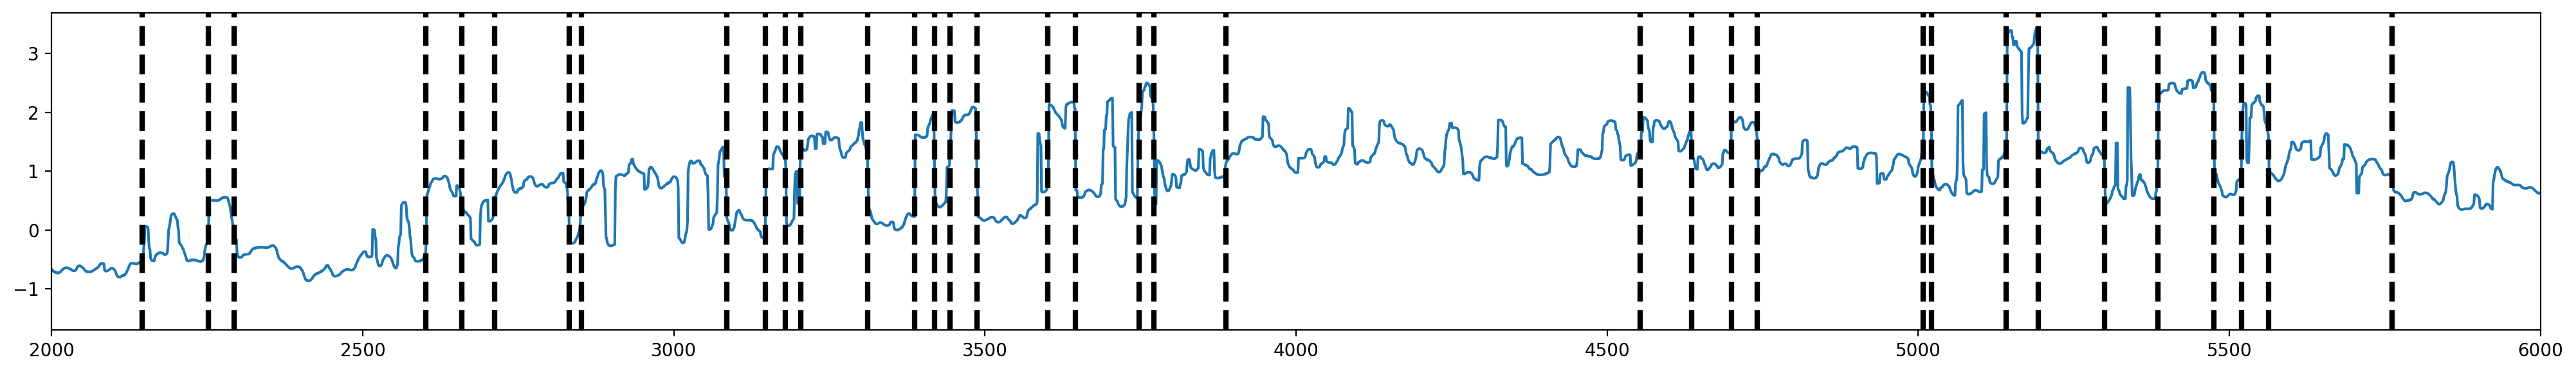

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 1
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model="rbf", min_size=5, jump=2).fit(x_denoise)
my_bkps = algo.predict(pen=10)

# show results
fig, ax_arr = rpt.display(x_denoise, bkps, my_bkps, figsize=(20, 3))
plt.xlim(2000, 6000)
plt.show()


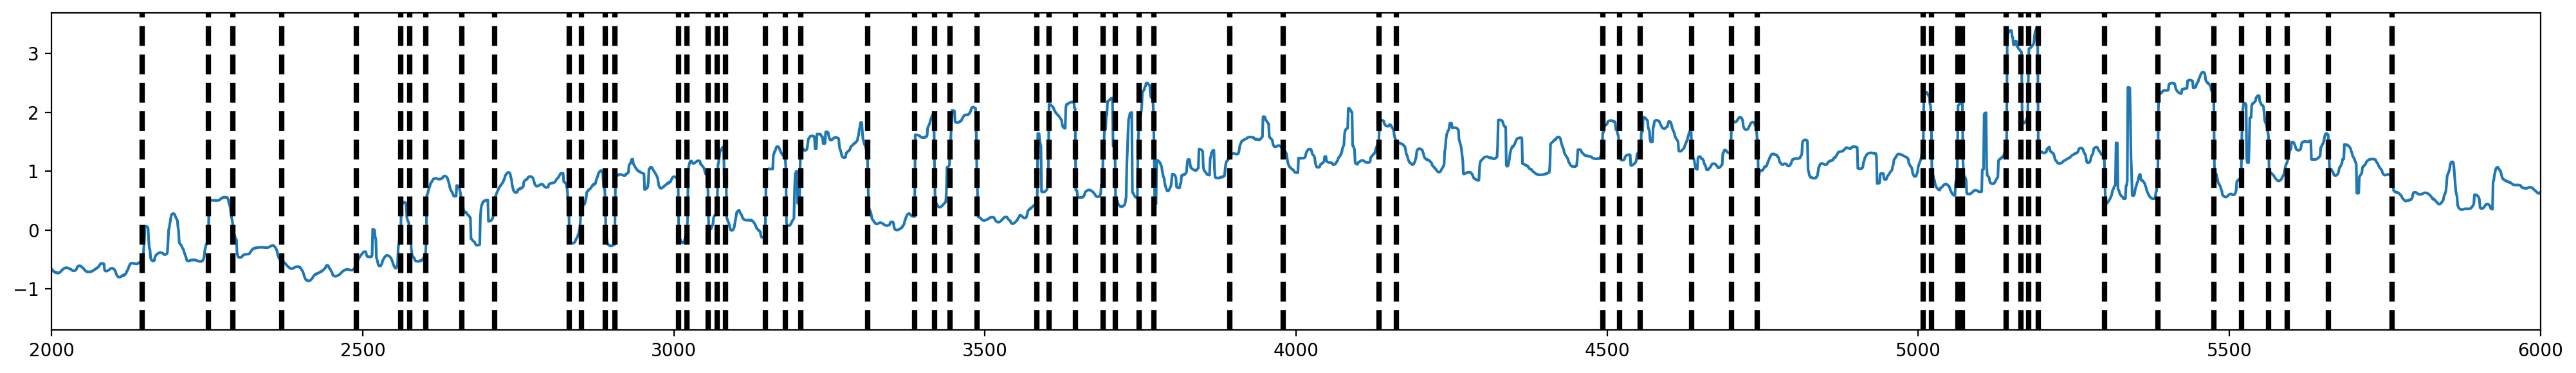

In [ ]:
# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model="rbf", min_size=5, jump=2).fit(x_denoise)
my_bkps = algo.predict(pen=5)

# show results
fig, ax_arr = rpt.display(x_denoise, bkps, my_bkps, figsize=(20, 3))
plt.xlim(2000, 6000)
plt.show()